We consider the connectivities of three spatial transcriptomics datasets, one from Zebrafish embryo, taken from [Satija et al. (2015)](https://doi.org/10.1038/nbt.3192); one from Drosophila embryo, pulled from [Karaiskos et al. (2017)](https://science.sciencemag.org/content/358/6360/194.full); and one from the Mouse brain cortex, from [Rodriques et al. (2019)](https://science.sciencemag.org/content/363/6434/1463.full). 

These are datafiles that Zixuan kindly gave to us, to see what the underlying spatial connectivity looks like for 'real' biological tissue. We will try and determine what are appropriate measures to then benchmark cell-cell communication methods, such as those used in SoptSC. 

In [1]:
# Load the relevant libraries
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import collections

Let us load the three datasets now. These are just the spatial coordinates of the tissue samples. Let's also try and plot the point cloud data to see what it looks like.

In [2]:
drosophila_positions = np.loadtxt("/Users/axelalmet/Documents/SpatialData/dm_geometry.txt", skiprows = 1) # Load the Drosophila data
zebrafish_positions = np.loadtxt("/Users/axelalmet/Documents/SpatialData/zf_geometry.txt", skiprows = 1) # Load the Zebrafish data
mouse_positions = np.loadtxt("/Users/axelalmet/Documents/SpatialData/slideseq-mouse-olfactory_bulb/positions.csv", skiprows = 1) # Load the mouse data

Text(0, 0.5, 'y')

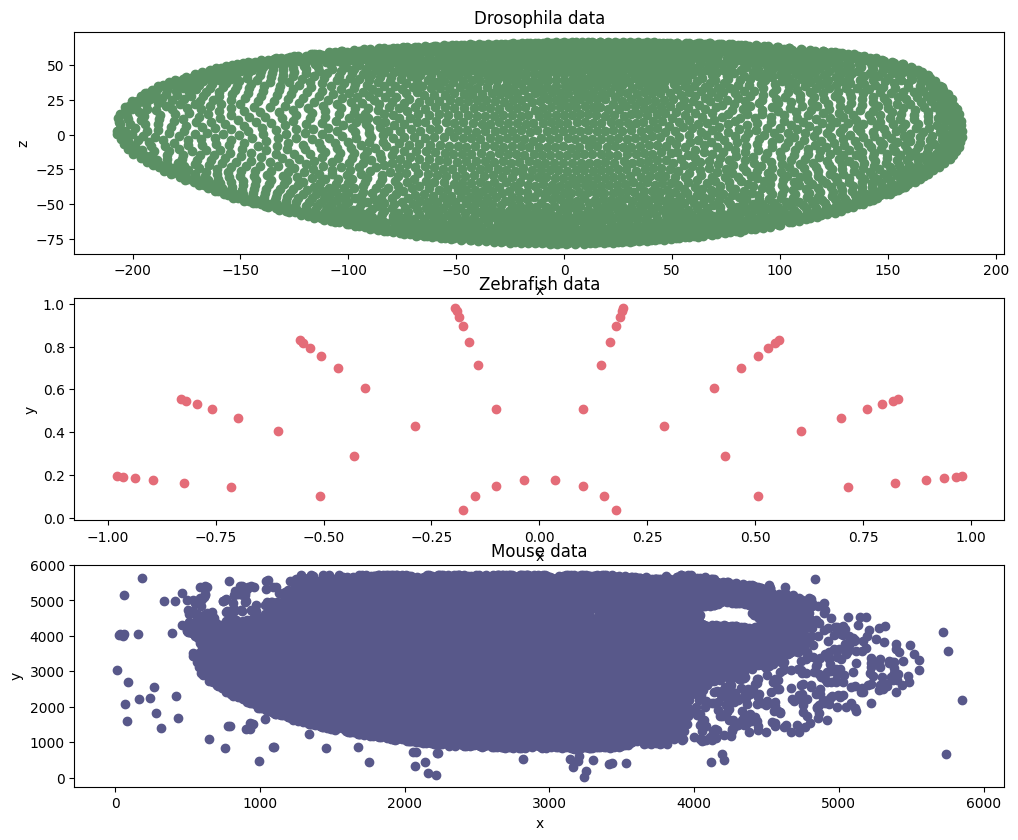

In [3]:
fig=plt.figure(figsize=(12,10), dpi= 100, facecolor='w', edgecolor='k')

# Plot the drosophila data
plt.subplot(311)
plt.scatter(drosophila_positions[:,0], drosophila_positions[:,2], color="#5B9064") # Plot the x-z data to get full 2D scope
plt.title("Drosophila data")
plt.xlabel("x")
plt.ylabel("z")

# Plot the zebrafish data
plt.subplot(312)
plt.scatter(zebrafish_positions[:,0], zebrafish_positions[:,1], color="#E46C78") # Plot the x-y data
plt.title("Zebrafish data")
plt.xlabel("x")
plt.ylabel("y")

# Plot the mouse data
plt.subplot(313)
plt.scatter(mouse_positions[:,0], mouse_positions[:,1], color="#58588A") # Plot the x-y data
plt.title("Mouse data")
plt.xlabel("x")
plt.ylabel("y")

Let us now generate the equivalent networks, based on a threshold distance, (roughly 1-2 cells apart). 

In [4]:
# First the drosophila data
drosophila_network = nx.Graph()
num_drosophila_nodes = drosophila_positions.shape[0]

# Generate the graph nodes and record their positions
for i in range(num_drosophila_nodes):
    drosophila_network.add_node(i, pos = np.array([drosophila_positions[i, 0], drosophila_positions[i, 2]])) # Record the x-z position
    
# We generate the edges based on nodes that are not the same and also within a certain distance of say, two cell widths
dist_cutoff = 10.0

for i in range(num_drosophila_nodes):
    for j in range(num_drosophila_nodes):
        if (i != j): # No loops!
            first_pos = drosophila_network.nodes[i]['pos']
            second_pos = drosophila_network.nodes[j]['pos']
            distance = ((first_pos[0] - second_pos[0])**2.0 + (first_pos[1] - second_pos[1])**2.0)**(0.5)
            
            # If the two nodes are close enough and the edge has not been added, we add it
            if ((distance < dist_cutoff)&(not drosophila_network.has_edge(i,j)) ): 
                drosophila_network.add_edge(i, j, dist = distance)
                
# The zebrafish data now
zebrafish_network = nx.Graph()
num_zebrafish_nodes = zebrafish_positions.shape[0]

# Generate the graph nodes and record their positions
for i in range(num_zebrafish_nodes):
    zebrafish_network.add_node(i, pos = np.array([zebrafish_positions[i, 0], zebrafish_positions[i, 1]])) # Record the x-y position
    
# We generate the edges based on nodes that are not the same and also within a certain distance of say, two cell widths
dist_cutoff = 0.1 # We change this because the spatial data for zebrafish has already been scaled.

for i in range(num_zebrafish_nodes):
    for j in range(num_zebrafish_nodes):
        if (i != j): # No loops!
            first_pos = zebrafish_network.nodes[i]['pos']
            second_pos = zebrafish_network.nodes[j]['pos']
            distance = ((first_pos[0] - second_pos[0])**2.0 + (first_pos[1] - second_pos[1])**2.0)**(0.5)
            
            # If the two nodes are close enough and the edge has not been added, we add it
            if ((distance < dist_cutoff)&(not zebrafish_network.has_edge(i,j)) ): 
                zebrafish_network.add_edge(i, j, dist = distance)
                
# And now the mouse data
mouse_network = nx.Graph()
num_mouse_nodes = mouse_positions.shape[0]

# Generate the graph nodes and record their positions
for i in range(num_mouse_nodes):
    mouse_network.add_node(i, pos = np.array([mouse_positions[i, 0], mouse_positions[i, 1]])) # Record the x-y position
    
# We generate the edges based on nodes that are not the same and also within a certain distance of say, two cell widths
dist_cutoff = 10 # 1.5 cell widths, let's say

for i in range(num_mouse_nodes):
    for j in range(num_mouse_nodes):
        if (i != j): # No loops!
            first_pos = mouse_network.nodes[i]['pos']
            second_pos = mouse_network.nodes[j]['pos']
            distance = ((first_pos[0] - second_pos[0])**2.0 + (first_pos[1] - second_pos[1])**2.0)**(0.5)
            
            # If the two nodes are close enough and the edge has not been added, we add it
            if ((distance < dist_cutoff)&(not mouse_network.has_edge(i,j)) ): 
                mouse_network.add_edge(i, j, dist = distance)

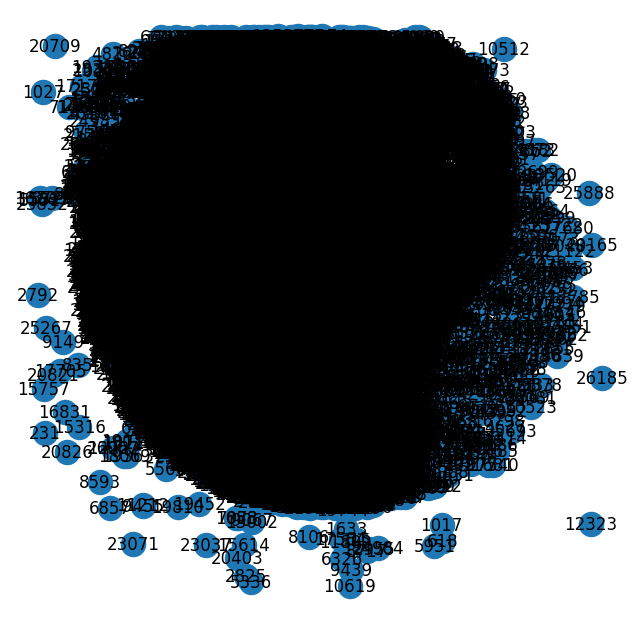

In [11]:
# Plot the networks now - seems to capture the spatial data well!
fig=plt.figure(figsize=(8, 8), dpi= 100, facecolor='w', edgecolor='k')
nx.draw_networkx(mouse_network, pos = nx.get_node_attributes(mouse_network, "pos"))

plt.axis("off")
plt.show()

We now look at the degree distributions and other measurements of these spatial networks.

Text(0.5, 0, 'Degree')

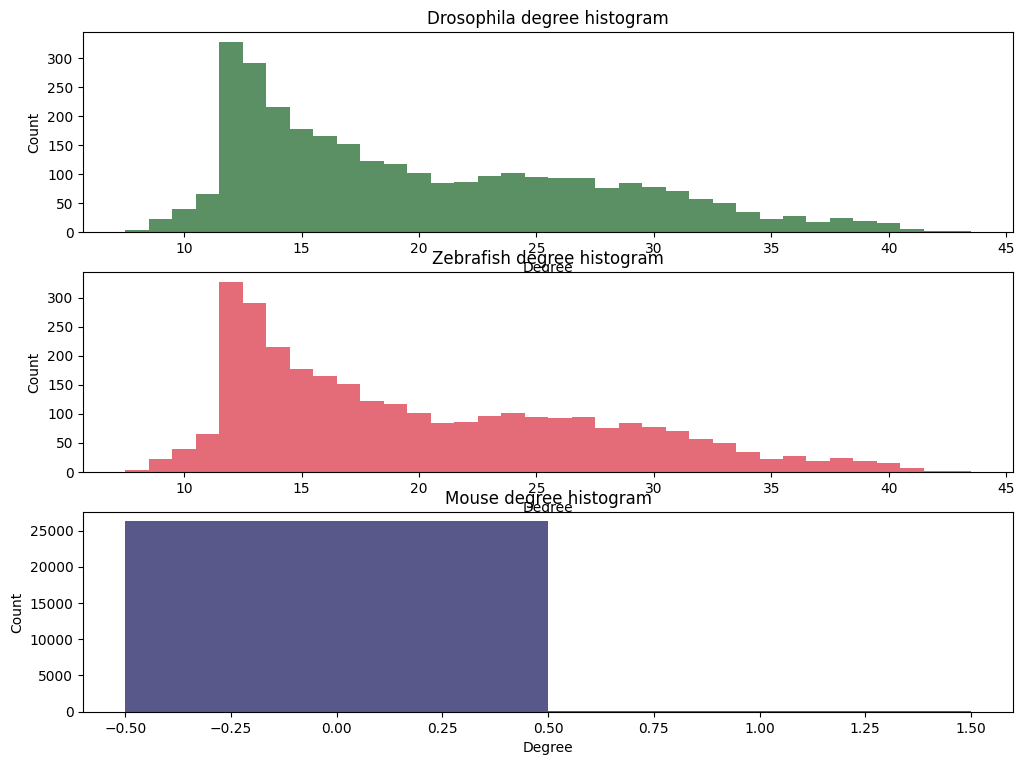

In [5]:
# Degree sequence for the drosophila data
drosophila_degree_sequence = sorted([d for n, d in drosophila_network.degree()], reverse=True)  # degree sequence
drosophilaDegreeCount = collections.Counter(drosophila_degree_sequence)
drosophila_deg, drosophila_cnt = zip(*drosophilaDegreeCount.items())

# Degree sequence for the zebrafish data
zebrafish_degree_sequence = sorted([d for n, d in zebrafish_network.degree()], reverse=True)  # degree sequence
zebrafishDegreeCount = collections.Counter(zebrafish_degree_sequence)
zebrafish_deg, zebrafish_cnt = zip(*zebrafishDegreeCount.items())

# Degree sequence for the mouse data
mouse_degree_sequence = sorted([d for n, d in mouse_network.degree()], reverse=True)  # degree sequence
mouseDegreeCount = collections.Counter(mouse_degree_sequence)
mouse_deg, mouse_cnt = zip(*mouseDegreeCount.items())

fig=plt.figure(figsize=(12,9), dpi= 100, facecolor='w', edgecolor='k')

# Plot the degree histograms
plt.subplot(311)
plt.bar(drosophila_deg, drosophila_cnt, width=1, color="#5B9064")
plt.title("Drosophila degree histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
# plt.ylim((0, 50))

plt.subplot(312)
plt.bar(drosophila_deg, drosophila_cnt, width=1, color="#E46C78")
plt.title("Zebrafish degree histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
# plt.ylim((0, 50))

plt.subplot(313)
plt.bar(mouse_deg, mouse_cnt, width=1, color="#58588A")
plt.title("Mouse degree histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
# plt.ylim((0, 50))